#### Get data

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [11]:
transcript_input_file = "../Datasets/transcript.csv"
customer_profile_file = "../Data Processing/customer_profile_df.csv"
offers_file = "../Data Processing/offers_df.csv"

# Data containing transaction information
transcript_df= pd.read_csv(transcript_input_file, index_col=0)
transactions_df = transcript_df.copy()[transcript_df["event"] == "transaction"].reset_index(drop=True)
# Extract amount
transactions_df["amount"] = [eval(value_dict).get("amount") for value_dict in transactions_df["value"]]
# Round to amount 2 dp
transactions_df["amount"] = round(transactions_df["amount"], 2)
# Drop event and value columns
transactions_df = transactions_df.drop(columns=["event", "value"])

# Data containing customer information
customer_profile_raw = pd.read_csv(customer_profile_file, index_col=0)
customer_profile_df = customer_profile_raw.copy()
customer_profile_df["became_member_on"] = pd.to_datetime(customer_profile_df["became_member_on"], format="%Y-%m-%d")

# Data containing offer information
offers_raw = pd.read_csv(offers_file, index_col=0)
offers_df = offers_raw.copy()

#### Obtain prior transaction and offer information

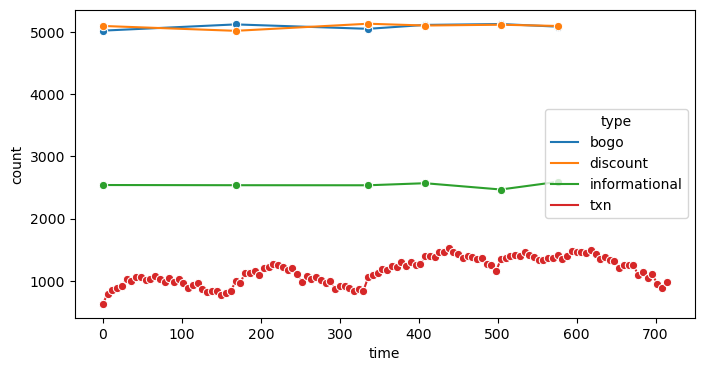

In [12]:
# Check data

# Transactions over time
txn_over_time_df = transactions_df.groupby("time")["amount"].count().reset_index(name="count")
txn_over_time_df["type"] = "txn"

# Offers over time
offers_over_time_df = offers_df.copy()[["person", "offer_id", "received_time", "offer_completed", "offer_type"]].groupby([
    "received_time", "offer_type"])["person"].count().reset_index(name="count").rename(columns={"offer_type": "type", "received_time": "time"})
combined_over_time_df = pd.concat([offers_over_time_df, txn_over_time_df])

plt.figure(figsize=(8, 4))
sns.lineplot(data=combined_over_time_df, x="time", y="count", hue="type", marker="o")
plt.show()

- 6 waves of offers 
- Times: Wk 1: 0, Wk 2: 168, Wk 3: [336, 408], Wk 4: [504, 576]

In [13]:
# Join time and amount as tuple
transactions_df["time_amt"] = list(zip(transactions_df["time"], transactions_df["amount"]))
# Group records by person
transactions_person_df = transactions_df.copy().groupby("person", sort=True)["time_amt"].apply(list).reset_index(name="time_amt_list")
# Join transaction information (person-level) to offers dataframe
offers_w_txn_df = offers_df.merge(transactions_person_df, on="person", how="left")
# Fill na with empty list
offers_w_txn_df["time_amt_list"] = offers_w_txn_df["time_amt_list"].fillna("").apply(list)

# Group offers by person
offers_person_df = offers_df.copy()[["person", "received_time"]].groupby("person")["received_time"].apply(list).reset_index(name="received_time_list")
# Join offer information (person-level) to offers dataframe
offers_w_txn_df = offers_w_txn_df.merge(offers_person_df, on="person", how="left")

def get_past_txn_offer_info(row):
    received_time = row["received_time"]
    full_time_amt_list = row["time_amt_list"]

    # Initialise values
    last_txn_time = 715 # use 715 to denote time of last txn when there was no last txn
    time_since_last_txn = 715 # use 715 to denote time since last txn when there was no last txn
    last_txn_amt = 0
    ave_txn_amt = 0
    num_txn_past_week = 0
    past_week_cutoff = max(received_time - (7*24), 0)

    # Only retain transactions that occurred before offer received
    filtered_time_amt_list = list(filter(lambda x: x[0] <= received_time, full_time_amt_list))

    if len(filtered_time_amt_list) > 0:
        # Extract txn_time and txn_amt from filtered list into tuples
        txn_times, txn_amts = list(zip(*filtered_time_amt_list))
        # Obtain info of last transaction
        last_txn_time = txn_times[-1]
        time_since_last_txn = received_time - last_txn_time
        last_txn_amt = txn_amts[-1]
        # Obtain frequency of transactions in the past week (7 days)
        num_txn_past_week = len(list(filter(lambda x: x >= past_week_cutoff, txn_times)))
        # Obtain average amount per txn
        ave_txn_amt = round(np.mean(txn_amts), 2)

    # Obtain frequency of offers in the past week (7 days)
    full_received_time_list = row["received_time_list"]
    # Only retain offers that occurred in 7 days prior to offer received 
    filtered_received_time_list = list(filter(
        lambda x: past_week_cutoff <= x < received_time, full_received_time_list))
    num_offers_past_week = len(filtered_received_time_list)

    return (last_txn_time, time_since_last_txn, last_txn_amt, ave_txn_amt, num_txn_past_week, num_offers_past_week)

In [14]:
# Initialise holder lists
last_txn_time_list = []
time_since_last_txn_list =[]
last_txn_amt_list = []
ave_txn_amt_list = []
num_txn_past_week_list = []
num_offers_past_week_list = []

for index, row in offers_w_txn_df.iterrows():
    last_txn_time, time_since_last_txn, last_txn_amt, ave_txn_amt, num_txn_past_week, num_offers_past_week = get_past_txn_offer_info(row)
    last_txn_time_list.append(last_txn_time)
    time_since_last_txn_list.append(time_since_last_txn)
    last_txn_amt_list.append(last_txn_amt)
    ave_txn_amt_list.append(ave_txn_amt)
    num_txn_past_week_list.append(num_txn_past_week)
    num_offers_past_week_list.append(num_offers_past_week)

offers_w_txn_df["last_txn_time"] = last_txn_time_list
offers_w_txn_df["time_since_last_txn"] = time_since_last_txn_list
offers_w_txn_df["last_txn_amt"] = last_txn_amt_list
offers_w_txn_df["ave_txn_amt"] = ave_txn_amt_list
offers_w_txn_df["num_txn_past_week"] = num_txn_past_week_list
offers_w_txn_df["num_offers_past_week"] = num_offers_past_week_list

#### Combine data

In [15]:
# Select relevant columns for analysis
customer_profile_cols = ["gender", "age", "income"]

offers_w_txn_customer_df = offers_w_txn_df.merge(customer_profile_df.copy()[customer_profile_cols + ["person"]], on="person", how="left")

offer_details_num_cols = ["reward", "difficulty", "duration", "num_channels"]
offer_details_bool_cols = ["used_email", "used_web", "used_social", "used_mobile", "offer_viewed"]
offer_details_cat_cols = ["offer_type"]
time_cols = ["received_time"]
id_cols = ["person", "offer_id"]
past_txn_offer_cols = ["time_since_last_txn", "last_txn_amt", "ave_txn_amt", "num_txn_past_week", "num_offers_past_week"]

relevant_cols = ["offer_completed"] + id_cols + customer_profile_cols + offer_details_num_cols + offer_details_bool_cols + offer_details_cat_cols + time_cols + past_txn_offer_cols
combined_df = offers_w_txn_customer_df.copy()[relevant_cols]

#### Clean data

In [16]:
# combined_df.info()

# Check missing values for demographic variables
missing_demographics_df = combined_df[combined_df["income"].isna()]
print("% of records with missing values: ", round((len(missing_demographics_df)/len(combined_df))*100, 2))
missing_demographics_df

% of records with missing values:  12.82


,offer_completed,person,offer_id,gender,age,income,reward,difficulty,duration,num_channels,...,used_social,used_mobile,offer_viewed,offer_type,received_time,time_since_last_txn,last_txn_amt,ave_txn_amt,num_txn_past_week,num_offers_past_week
62,0,0092a132ead946ceb30d11a1ed513d20,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,118,NaN,5,5,7,3,...,0,1,1,bogo,0.0,715.0,0.00,0.00,0,0
63,0,0092a132ead946ceb30d11a1ed513d20,f19421c1d4aa40978ebb69ca19b0e20d,NaN,118,NaN,5,5,5,4,...,1,1,1,bogo,168.0,715.0,0.00,0.00,0,1
64,0,0092a132ead946ceb30d11a1ed513d20,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,118,NaN,3,7,7,4,...,1,1,1,discount,336.0,162.0,0.74,0.74,1,1
65,0,0092a132ead946ceb30d11a1ed513d20,ae264e3637204a6fb9bb56bc8210ddfd,NaN,118,NaN,10,10,7,3,...,1,1,1,bogo,408.0,54.0,0.48,0.61,1,1
66,0,0092a132ead946ceb30d11a1ed513d20,5a8bc65990b245e5a138643cd4eb9837,NaN,118,NaN,0,0,3,3,...,1,1,1,informational,504.0,150.0,0.48,0.61,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76265,0,6e1d4ac6dc3d4a9788b1b82ea4ae6ebf,fafdcd668e3743c1bb461111dcafc2a4,NaN,118,NaN,2,10,10,4,...,1,1,1,discount,576.0,6.0,0.43,0.38,1,0
76266,0,912b9f623b9e4b4eb99b6dc919f09a93,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,118,NaN,10,10,5,4,...,1,1,1,bogo,576.0,715.0,0.00,0.00,0,0
76270,0,bfd771e3110b499cba04282c76701688,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,118,NaN,3,7,7,4,...,1,1,1,discount,576.0,54.0,0.66,2.17,2,0
76273,0,c77659a28bf84aaa95b1ca4bbb2b56d0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,118,NaN,5,5,5,4,...,1,1,1,bogo,576.0,18.0,2.42,2.65,2,0


- Customer profiles with missing income also have missing gender and inaccurate age values
- These missing demographic values cannot be easily imputed without affecting the integrity of the dataset, especially since it forms a substantial % of the dataset and the limited information available
- Decision: Remove these records

In [17]:
# Remove records with null demographics
combined_df = combined_df[combined_df["income"].notna()].reset_index(drop=True)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66501 entries, 0 to 66500
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   offer_completed       66501 non-null  int64  
 1   person                66501 non-null  object 
 2   offer_id              66501 non-null  object 
 3   gender                66501 non-null  object 
 4   age                   66501 non-null  int64  
 5   income                66501 non-null  float64
 6   reward                66501 non-null  int64  
 7   difficulty            66501 non-null  int64  
 8   duration              66501 non-null  int64  
 9   num_channels          66501 non-null  int64  
 10  used_email            66501 non-null  int64  
 11  used_web              66501 non-null  int64  
 12  used_social           66501 non-null  int64  
 13  used_mobile           66501 non-null  int64  
 14  offer_viewed          66501 non-null  int64  
 15  offer_type         

In [18]:
# Save to csv file
combined_df.to_csv("reg_combined_df.csv")